## Import Libraries

In [348]:
import os
import pathlib
import json
import sqlalchemy as db

from datetime import datetime, date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected=True)


## Configurations

In [263]:
import quandl
import pandas_datareader as pdr
from pycoingecko import CoinGeckoAPI

quandl.ApiConfig.api_key = "f6Y8avFQZwXp37ftC1_6"
cg = CoinGeckoAPI()


project_dir = pathlib.Path().absolute()
workdir = project_dir.parent
# print(f"{project_dir}\n{workdir}")

## Build functions

In [264]:

def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)


def get_json_data(data_id, json_path, provider):
    """Download and cache JSON data, return as a dataframe."""
    
    cache_path = f"{workdir}\\02_Resources\{data_id}.json"
    try:        
        f = open(cache_path, 'rb')
        df = pd.read_json(f)   
        print(f"Loaded {cache_path} from cache")
    except (OSError, IOError) as e:
        print(f"Downloading {data_id} from {provider}")
        df = pd.read_json(json_path)
        df.to_json(cache_path)
        print(f"Cached {data_id} at {cache_path}")
    return df



## Quandl Data import

def get_quandl_data(quandl_id):
    """" Download quandl data and load to json """
    
    data_id = quandl_id.replace('/', '-')
    provider = "Quandl"
    df = quandl.get(quandl_id, returns="pandas")
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


    
## Coingecko Data import



## Data Reader Data import

def get_datareader_data(datareader_id, provider):
    """" Download datareader data and load to json """
    data_id = datareader_id
    df = pdr.DataReader(datareader_id, provider)
    if df.shape[0]!=df.index.nunique():
        idx = np.unique(df.index.values, return_index=True)[1]
        df = df.iloc[idx]    
            
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


## Poloniex Data import

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2014-01-01', '%Y-%m-%d') # get data from the start of 2014
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_poloniex_data(poloniex_pair):
    """Retrieve cryptocurrency data from poloniex"""
    
    data_id = poloniex_pair
    provider="Poloniex"
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    df = get_json_data(data_id, json_url, poloniex_pair)
    df = df.set_index('date')
    return df

## Initial Data Exploration

### Look at Quandl Data

In [265]:
df_sample_quandl_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache


In [266]:
df_sample_quandl_kraken.head()

Open       High        Low      Close  Volume (BTC)  \
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709

In [267]:
df_sample_quandl_kraken.index[0]

Timestamp('2014-01-07 00:00:00')

In [268]:
df_sample_quandl_kraken.index[-1]

Timestamp('2021-04-06 00:00:00')

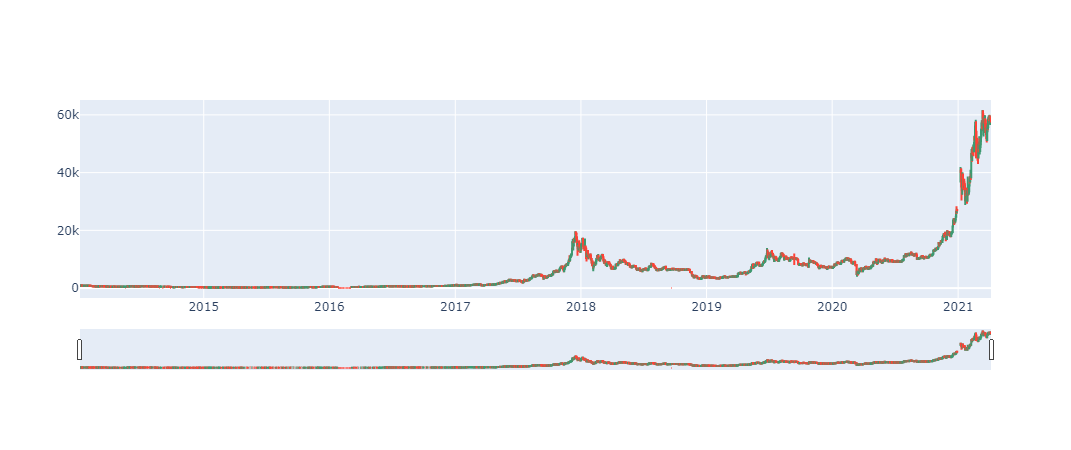

In [269]:
fig = go.Figure(data=[go.Candlestick(x=df_sample_quandl_kraken.index,
                open=df_sample_quandl_kraken['Open'],
                high=df_sample_quandl_kraken['High'],
                low=df_sample_quandl_kraken['Low'],
                close=df_sample_quandl_kraken['Close'])])
fig.show()

### Look at Coingecko market & exchange data

In [270]:
coins_list = cg.get_coins_list()
coin_names = []
for item in coins_list:
    coin_names.append(item['name'])

In [271]:
# jprint(coins_list)

In [272]:
markets_list = cg.get_coins_markets(vs_currency='usd')
market_names = []
for item in markets_list:
    market_names.append(item['name'])
len(market_names)

100

In [273]:
# jprint(markets_list)

In [274]:
df_cg_markets = pd.DataFrame.from_dict(markets_list)
df_cg_markets.head()

id symbol          name  \
0      bitcoin    btc       Bitcoin   
1     ethereum    eth      Ethereum   
2  binancecoin    bnb  Binance Coin   
3       tether   usdt        Tether   
4       ripple    xrp           XRP   

                                               image  current_price  \
0  https://assets.coingecko.com/coins/images/1/la...   56905.000000   
1  https://assets.coingecko.com/coins/images/279/...    1999.950000   
2  https://assets.coingecko.com/coins/images/825/...     372.480000   
3  https://assets.coingecko.com/coins/images/325/...       0.997565   
4  https://assets.coingecko.com/coins/images/44/l...       0.927698   

      market_cap  market_cap_rank  fully_diluted_valuation  total_volume  \
0  1063461825127                1             1.195800e+12   67838020284   
1   232948724981                2                      NaN   35889175877   
2    57511348857                3             6.346592e+10    3715005539   
3    43063003970                4                      NaN  154901242515   
4    42268094214                5                      NaN   23934084818   

   high_24h  ...  total_supply   max_supply       ath  ath_change_percentage  \
0  59249.00  ...  2.100000e+07   21000000.0  61712.00               -7.72789   
1   2129.90  ...           NaN          NaN   2153.08               -6.26274   
2    412.45  ...  1.705337e+08  170533651.9    412.45               -9.76901   
3      1.00  ...  4.316810e+10          NaN      1.32              -24.60366   
4      1.10  ...  1.000000e+11          NaN      3.40              -72.90776   

                   ath_date        atl  atl_change_percentage  \
0  2021-03-13T20:49:26.606Z  67.810000            83875.35770   
1  2021-04-06T01:14:31.985Z   0.432979           466029.84683   
2  2021-04-07T06:53:56.811Z   0.039818           934561.48353   
3  2018-07-24T00:00:00.000Z   0.572521               74.24085   
4  2018-01-07T00:00:00.000Z   0.002686            34175.70671   

                   atl_date  \
0  2013-07-06T00:00:00.000Z   
1  2015-10-20T00:00:00.000Z   
2  2017-10-19T00:00:00.000Z   
3  2015-03-02T00:00:00.000Z   
4  2014-05-22T00:00:00.000Z   

                                                 roi              last_updated  
0                                               None  2021-04-07T11:29:13.464Z  
1  {'times': 46.08660387659373, 'currency': 'btc'...  2021-04-07T11:29:27.446Z  
2                                               None  2021-04-07T11:28:13.162Z  
3                                               None  2021-04-07T11:06:51.408Z  
4                                               None  2021-04-07T11:29:32.079Z  

[5 rows x 26 columns]

In [275]:
exchanges_list = cg.get_exchanges_list()
exchange_names = []
for item in exchanges_list:
    exchange_names.append(item['name'])
len(exchange_names)

100

In [276]:
# jprint(exchanges_list)

In [277]:
df_cg_exchanges = pd.DataFrame.from_dict(exchanges_list)
df_cg_exchanges.head()

id          name  year_established                 country  \
0   binance       Binance            2017.0          Cayman Islands   
1      gdax  Coinbase Pro            2012.0           United States   
2    kraken        Kraken            2011.0           United States   
3  bitfinex      Bitfinex            2014.0  British Virgin Islands   
4      gate       Gate.io               NaN               Hong Kong   

  description                         url  \
0                https://www.binance.com/   
1                https://www.coinbase.com   
2              https://r.kraken.com/Q1m9x   
3                https://www.bitfinex.com   
4                        https://gate.io/   

                                               image has_trading_incentive  \
0  https://assets.coingecko.com/markets/images/52...                 False   
1  https://assets.coingecko.com/markets/images/23...                 False   
2  https://assets.coingecko.com/markets/images/29...                 False   
3  https://assets.coingecko.com/markets/images/4/...                 False   
4  https://assets.coingecko.com/markets/images/60...                 False   

   trust_score  trust_score_rank  trade_volume_24h_btc  \
0           10                 1         801344.108556   
1           10                 2          59256.821728   
2           10                 3          34538.954182   
3           10                 4          26256.187052   
4           10                 5          22214.942667   

   trade_volume_24h_btc_normalized  
0                    801344.108556  
1                     59256.821728  
2                     34538.954182  
3                     26256.187052  
4                     22214.942667

### Look at Coingecko BTC data

In [278]:
start_date = datetime.strptime("2014-01-07", "%Y-%m-%d")
end_date = datetime.strptime("2021-04-01", "%Y-%m-%d")
timestamp_start = datetime.timestamp(start_date)
timestamp_end = datetime.timestamp(end_date)

In [279]:
btc_charts_data = cg.get_coin_market_chart_range_by_id("bitcoin", "usd", timestamp_start, timestamp_end)

In [280]:
# jprint(btc_charts_data)

In [281]:
for key, value in enumerate(btc_charts_data):
    elements = []
    for element in btc_charts_data[value]:
        elements.append(element)
    print(f"{value}: # {len(elements)}")

prices: # 2640
market_caps: # 2639
total_volumes: # 2640


In [282]:
df_btc_charts_data_mc = pd.DataFrame.from_dict(btc_charts_data['market_caps'])
df_btc_charts_data_mc.rename(columns={0:'timestamp', 1:'market_cap'}, inplace=True)
df_btc_charts_data_mc['datetime'] = pd.to_datetime(df_btc_charts_data_mc['timestamp'], unit='ms')
df_btc_charts_data_mc.drop('timestamp', axis=1, inplace=True)
df_btc_charts_data_mc.set_index('datetime', inplace=True)
print(f"Duplicated indices: {df_btc_charts_data_mc.index.duplicated().sum()}")
df_btc_charts_data_mc.tail()

Duplicated indices: 0


market_cap
datetime                
2021-03-27  1.027210e+12
2021-03-28  1.042184e+12
2021-03-29  1.039334e+12
2021-03-30  1.075942e+12
2021-03-31  1.095293e+12

In [283]:
df_btc_charts_data_mc = pd.DataFrame.from_dict(btc_charts_data['market_caps'])
df_btc_charts_data_mc.rename(columns={0:'timestamp', 1:'market_cap'}, inplace=True)

df_btc_charts_data_pc = pd.DataFrame.from_dict(btc_charts_data['prices'])
df_btc_charts_data_pc.rename(columns={0:'timestamp', 1:'price'}, inplace=True)

df_btc_charts_data_vol = pd.DataFrame.from_dict(btc_charts_data['total_volumes'])
df_btc_charts_data_vol.rename(columns={0:'timestamp', 1:'volume'}, inplace=True)


In [284]:
df_btc_charts_merged = df_btc_charts_data_mc.merge(df_btc_charts_data_pc, how="inner", 
                                                   left_on='timestamp', right_on='timestamp').merge(df_btc_charts_data_vol,
                                                                                                                how='inner', left_on='timestamp', 
                                                                                                                 right_on='timestamp')
df_btc_charts_merged.tail()

timestamp    market_cap         price        volume
2634  1616803200000  1.027210e+12  55033.100480  5.544256e+10
2635  1616889600000  1.042184e+12  55832.418110  4.728575e+10
2636  1616976000000  1.039334e+12  55728.101328  4.931585e+10
2637  1617062400000  1.075942e+12  57634.928694  5.738704e+10
2638  1617148800000  1.095293e+12  58668.628337  5.238754e+10

In [285]:
df_btc_charts_merged['datetime'] = pd.to_datetime(df_btc_charts_merged['timestamp'], unit='ms')
df_cg_btc_data = df_btc_charts_merged.set_index('datetime')
df_cg_btc_data.drop('timestamp', axis=1, inplace=True)
df_cg_btc_data.tail()

market_cap         price        volume
datetime                                            
2021-03-27  1.027210e+12  55033.100480  5.544256e+10
2021-03-28  1.042184e+12  55832.418110  4.728575e+10
2021-03-29  1.039334e+12  55728.101328  4.931585e+10
2021-03-30  1.075942e+12  57634.928694  5.738704e+10
2021-03-31  1.095293e+12  58668.628337  5.238754e+10

In [286]:
print(f"Duplicated indices: {df_cg_btc_data.index.duplicated().sum()}")
print(df_cg_btc_data.nunique())

Duplicated indices: 0
market_cap    2639
price         2638
volume        2639
dtype: int64


In [287]:
df_cg_btc_data[df_cg_btc_data.index.duplicated()]

Empty DataFrame
Columns: [market_cap, price, volume]
Index: []

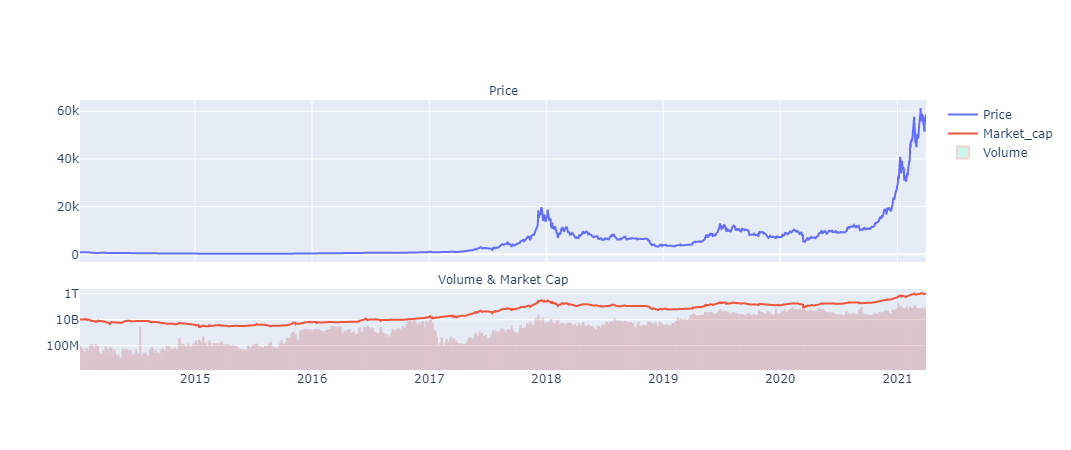

In [288]:
fig = go.Figure()

date = df_cg_btc_data.index
price = df_cg_btc_data['price']
market_cap = df_cg_btc_data['market_cap']
volume = df_cg_btc_data['volume']

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('Price', 'Volume & Market Cap'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=date, y=price,
                    mode='lines',
                    name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=date, y=market_cap,
                    name='Market_cap'), row=2, col=1)

fig.add_trace(go.Bar(x=date, y=volume,
                     name='Volume',
                     opacity=0.2,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)



fig.update_layout(yaxis2_type="log")

fig.show()

### Look at Yahoo Finance BTC data

In [289]:
df_yahoo_btc_data = get_datareader_data('BTC-USD', "yahoo")
df_yahoo_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC-USD.json from cache


High           Low          Open         Close  \
2021-04-02  60110.269531  57603.890625  59397.410156  57603.890625   
2021-04-03  58913.746094  57168.675781  57604.839844  58758.554688   
2021-04-04  59891.296875  57694.824219  58760.875000  59057.878906   
2021-04-05  59479.578125  57646.808594  59171.933594  58192.359375   
2021-04-07  58731.144531  57497.531250  57841.871094  58011.585938   

                 Volume     Adj Close  
2021-04-02  59641344484  57603.890625  
2021-04-03  50749662970  58758.554688  
2021-04-04  60706272115  59057.878906  
2021-04-05  66058027988  58192.359375  
2021-04-07  70141157376  58011.585938

### Comparison Chart BTC Closing Price

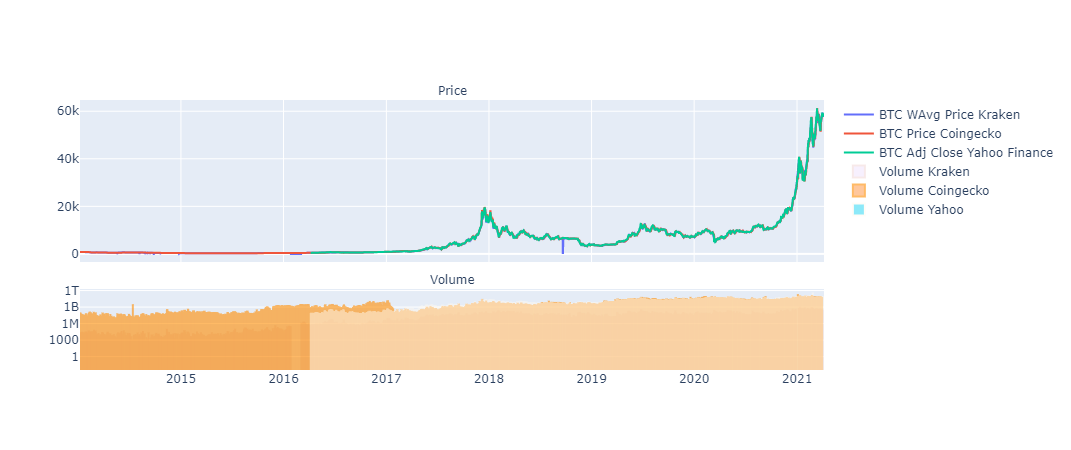

In [307]:
fig = go.Figure()

quandl_kraken = df_sample_quandl_kraken
coingecko = df_cg_btc_data
yahoo = df_yahoo_btc_data

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('Price', 'Volume'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=quandl_kraken.index, y=quandl_kraken['Weighted Price'],
                         mode='lines',
                         name='BTC WAvg Price Kraken'), row=1, col=1)

fig.add_trace(go.Scatter(x=coingecko.index, y=coingecko['price'],
                         mode='lines',
                         name='BTC Price Coingecko'), row=1, col=1)

fig.add_trace(go.Scatter(x=yahoo.index, y=yahoo['Adj Close'],
                         mode='lines',
                         name='BTC Adj Close Yahoo Finance'), row=1, col=1)


fig.add_trace(go.Bar(x=quandl_kraken.index, y=quandl_kraken['Volume (Currency)'],
                     name='Volume Kraken',
                     opacity=0.1,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.add_trace(go.Bar(x=coingecko.index, y=coingecko['volume'],
                     name='Volume Coingecko',
                     opacity=0.6,
                     marker=dict(
                         line=dict(color='darkorange', width=2)
                     )), row=2, col=1)

fig.add_trace(go.Bar(x=yahoo.index, y=yahoo['Volume'],
                     name='Volume Yahoo',
                     opacity=0.5,
                     marker=dict(
                         line=dict(color='floralwhite', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)

fig.update_layout(yaxis2_type="log")

fig.show()

## Data Ingestion: Populate BTC Data

### Inject more Exchange data from Quandl

In [308]:
from quandl.errors.quandl_error import NotFoundError

exchanges = list(df_cg_exchanges['id'].str.upper())

df_run_all = []
    
for exchange in exchanges:
    exchange_code = f"BCHARTS/{exchange}USD"
   
    try:
        df = get_quandl_data(exchange_code)
        df['Exchange'] = exchange
        df_run_all.append(df)
        
    except NotFoundError as e:
        continue

df_quandl_btc_data = pd.concat(df_run_all)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFINEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITSTAMPUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFLYERUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-CEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-OKCOINUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-ITBITUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-HITBTCUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-P2PB2BUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-EXMOUSD.json from cache
Cached BCHARTS-BITBAYUSD at C:\Users\akosr\CAS_DAENG\crypto_

In [314]:
df_quandl_btc_data.rename(columns={'Volume (BTC)': 'Volume_BTC', 'Volume (Currency)': 'Volume_USD'}, inplace=True)
df_quandl_btc_data.tail()

Open      High       Low     Close   Volume_BTC    Volume_USD  \
2011-09-13      5.80      6.00      5.65      5.97    58.371382  3.460974e+02   
2011-09-14      5.58      5.72      5.52      5.53    61.145984  3.418548e+02   
2011-09-15      5.12      5.24      5.00      5.13    80.140795  4.082590e+02   
2011-09-16      4.82      4.87      4.80      4.85    39.914007  1.937631e+02   
2011-09-17      4.87      4.87      4.87      4.87     0.300000  1.461000e+00   
...              ...       ...       ...       ...          ...           ...   
2021-04-05  58173.70  59238.30  56869.30  59028.50    82.271525  4.797438e+06   
2021-04-06  59120.00  59462.80  57377.10  57915.40  2553.929973  1.491001e+08   
2021-04-06  59068.10  59386.30  57416.00  57850.00   113.016463  6.593963e+06   
2021-04-06  59135.36  59473.90  57216.00  57928.35  2647.158128  1.543646e+08   
2021-04-06  54949.95  58500.00  54949.95  58422.00     0.013579  7.658116e+02   

            Weighted Price  Exchange  
2011-09-13        5.929231  BITSTAMP  
2011-09-14        5.590798  BITSTAMP  
2011-09-15        5.094272  BITSTAMP  
2011-09-16        4.854515  BITSTAMP  
2011-09-17        4.870000  BITSTAMP  
...                    ...       ...  
2021-04-05    58312.258352       CEX  
2021-04-06    58380.658352    KRAKEN  
2021-04-06    58345.154697       CEX  
2021-04-06    58313.341328  BITSTAMP  
2021-04-06    56395.638375    BITBAY  

[16651 rows x 8 columns]

### Inject BTC Data from Poloniex

In [322]:
df_poloniex_btc_data = get_poloniex_data("USDT_BTC")
df_poloniex_btc_data.columns= df_poloniex_btc_data.columns.str.title()
df_poloniex_btc_data = df_poloniex_btc_data.rename(columns={'Volume': 'Volume_USD', 'Quotevolume': 'Volume_BTC',  
                                                     'Weightedaverage': 'Weighted Price'})

df_poloniex_btc_data['Exchange'] = 'POLONIEX'
column_names=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD', 'Weighted Price', 'Exchange']
df_poloniex_btc_data = df_poloniex_btc_data.reindex(columns=column_names)

df_poloniex_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\USDT_BTC.json from cache


Open          High           Low         Close  \
date                                                                 
2021-03-27  55008.350978  56645.325460  53967.742633  55855.274815   
2021-03-28  55828.000000  56517.750699  54700.000000  55773.962120   
2021-03-29  55769.134151  58332.142365  54940.245881  57620.809447   
2021-03-30  57614.000000  59360.000000  57085.000000  58748.000000   
2021-03-31  58748.000000  59782.490733  56846.531521  58743.337525   

             Volume_BTC    Volume_USD  Weighted Price  Exchange  
date                                                             
2021-03-27   521.355309  2.880248e+07    55245.398905  POLONIEX  
2021-03-28   426.410099  2.379101e+07    55793.739993  POLONIEX  
2021-03-29   786.820766  4.498012e+07    57166.920136  POLONIEX  
2021-03-30   508.525830  2.964910e+07    58304.022460  POLONIEX  
2021-03-31  1025.147455  6.003219e+07    58559.565409  POLONIEX

### Append Poloniex Data to have the final BTC Dataset

In [338]:
df_btc_data = df_quandl_btc_data.append(df_poloniex_btc_data)
df_btc_data.sort_values(by=['Exchange'])
df_btc_data

Open          High           Low         Close  \
2011-09-13      5.800000      6.000000      5.650000      5.970000   
2011-09-14      5.580000      5.720000      5.520000      5.530000   
2011-09-15      5.120000      5.240000      5.000000      5.130000   
2011-09-16      4.820000      4.870000      4.800000      4.850000   
2011-09-17      4.870000      4.870000      4.870000      4.870000   
...                  ...           ...           ...           ...   
2021-03-27  55008.350978  56645.325460  53967.742633  55855.274815   
2021-03-28  55828.000000  56517.750699  54700.000000  55773.962120   
2021-03-29  55769.134151  58332.142365  54940.245881  57620.809447   
2021-03-30  57614.000000  59360.000000  57085.000000  58748.000000   
2021-03-31  58748.000000  59782.490733  56846.531521  58743.337525   

             Volume_BTC    Volume_USD  Weighted Price  Exchange  
2011-09-13    58.371382  3.460974e+02        5.929231  BITSTAMP  
2011-09-14    61.145984  3.418548e+02        5.590798  BITSTAMP  
2011-09-15    80.140795  4.082590e+02        5.094272  BITSTAMP  
2011-09-16    39.914007  1.937631e+02        4.854515  BITSTAMP  
2011-09-17     0.300000  1.461000e+00        4.870000  BITSTAMP  
...                 ...           ...             ...       ...  
2021-03-27   521.355309  2.880248e+07    55245.398905  POLONIEX  
2021-03-28   426.410099  2.379101e+07    55793.739993  POLONIEX  
2021-03-29   786.820766  4.498012e+07    57166.920136  POLONIEX  
2021-03-30   508.525830  2.964910e+07    58304.022460  POLONIEX  
2021-03-31  1025.147455  6.003219e+07    58559.565409  POLONIEX  

[18884 rows x 8 columns]

## Organize Data

In [363]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS BTC_Data
              (
                PriceID INT PRIMARY KEY,
                Date DATE NOT NULL, 
                Open MONEY NULL DEFAULT 0,
                High MONEY NULL DEFAULT 0,
                Low MONEY NULL DEFAULT 0,
                Close MONEY NULL DEFAULT 0,
                WeightedPrice MONEY NULL DEFAULT 0,
                Volume_USD MONEY NULL DEFAULT 0,
                Volume_BTC REAL NULL DEFAULT 0,
                Currency VARCHAR(5) NULL DEFAULT "USD",
                FOREIGN KEY(MarketID) REFERENCES Market(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchange(ExchangeID) ON DELETE CASCADE
                          
              ); ''')
    con.close()

2021-04-07 15:51:39,925 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS BTC_Data
              (
                PriceID INT PRIMARY KEY,
                Date DATE NOT NULL, 
                Open MONEY NULL DEFAULT 0,
                High MONEY NULL DEFAULT 0,
                Low MONEY NULL DEFAULT 0,
                Close MONEY NULL DEFAULT 0,
                WeightedPrice MONEY NULL DEFAULT 0,
                Volume_USD MONEY NULL DEFAULT 0,
                Volume_BTC REAL NULL DEFAULT 0,
                Currency VARCHAR(5) NULL DEFAULT "USD",
                FOREIGN KEY(MarketID) REFERENCES Market(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchange(ExchangeID) ON DELETE CASCADE
                          
              ); 
2021-04-07 15:51:39,926 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-07 15:51:39,928 INFO sqlalchemy.engine.Engine COMMIT


In [361]:
inspector = db.inspect(engine)
inspector.get_table_names()

2021-04-07 15:46:29,314 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-04-07 15:46:29,315 INFO sqlalchemy.engine.Engine [raw sql] ()


['btc_data']

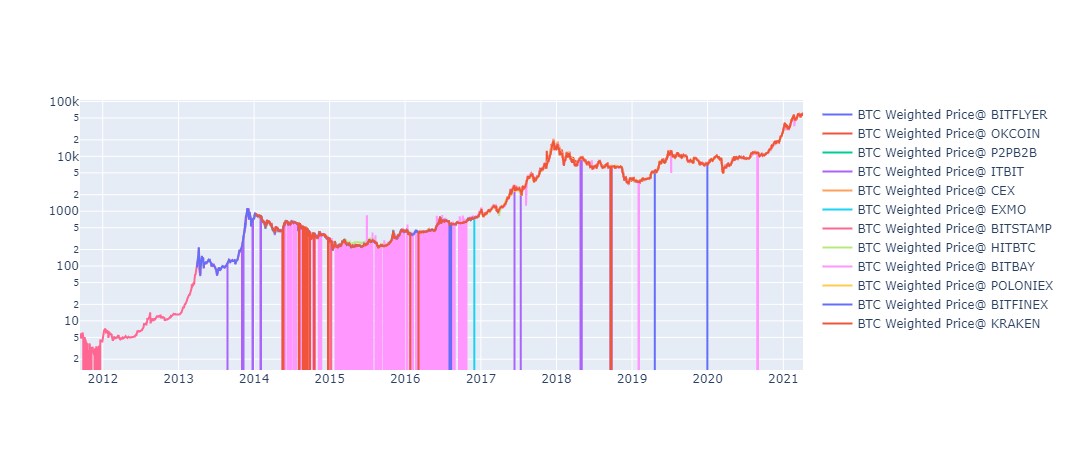

In [329]:
fig = go.Figure()

exchanges_lab = set(df_btc_data['Exchange'])

for exchange in exchanges_lab:
    fig.add_trace(go.Scatter(x=df_btc_data[df_btc_data['Exchange']==exchange].index, 
                             y=df_btc_data[df_btc_data['Exchange']==exchange]['Weighted Price'],
                             mode='lines',
                             name=f"BTC Weighted Price@ {exchange}"))

fig.update_yaxes(type="log")
    
fig.show()

## Data Ingestion: Populate Altcoin Data

In [86]:
df_cg_markets['symbol']

0        btc
1        eth
2        bnb
3        xrp
4       usdt
       ...  
95       rsr
96      ankr
97       amp
98    xsushi
99      btmx
Name: symbol, Length: 100, dtype: object

In [87]:
from quandl.errors.quandl_error import NotFoundError

markets = list(df_cg_markets['symbol'].str.upper())

df_run_mkt_new = []
    
for market in markets:
    market_code = f"BITFINEX/{market}BTC"
   
    try:
        df = get_quandl_data(market_code)
        df['Market'] = market
        df_run_mkt_new.append(df)
        
    except NotFoundError as e:
        continue

df_altcoin_quandl = pd.concat(df_run_mkt_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ETHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XRPBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-DOTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ADABTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-LTCBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BCHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XLMBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-TRXBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-VETBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BTTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-EOSBTC.json

In [88]:
df_altcoin_quandl = df_altcoin_quandl.sort_index()

In [89]:
df_altcoin_quandl

High       Low       Mid      Last       Bid       Ask  \
2014-04-15  0.025870  0.024502  0.025606  0.025669  0.025366  0.025845   
2014-04-16  0.026310  0.025050  0.025303  0.025111  0.025110  0.025497   
2014-04-17  0.026025  0.025111  0.025445  0.025550  0.025341  0.025550   
2014-04-18  0.026439  0.025001  0.025251  0.025486  0.025094  0.025408   
2014-04-19  0.025789  0.025000  0.025616  0.025460  0.025451  0.025782   
...              ...       ...       ...       ...       ...       ...   
2021-04-06  0.000780  0.000726  0.000742  0.000742  0.000742  0.000742   
2021-04-06  0.000019  0.000014  0.000018  0.000018  0.000018  0.000018   
2021-04-06  0.001267  0.000764  0.001189  0.001197  0.001186  0.001192   
2021-04-06  0.000033  0.000030  0.000033  0.000033  0.000033  0.000033   
2021-04-06  0.000018  0.000016  0.000018  0.000018  0.000018  0.000018   

                  Volume Market  
2014-04-15  1.430187e+03    LTC  
2014-04-16  1.774144e+03    LTC  
2014-04-17  9.852923e+02    LTC  
2014-04-18  1.372240e+03    LTC  
2014-04-19  2.330634e+03    LTC  
...                  ...    ...  
2021-04-06  1.220538e+04    DOT  
2021-04-06  3.420721e+07    XRP  
2021-04-06  1.442146e+04    BTG  
2021-04-06  4.974565e+04    ZRX  
2021-04-06  4.073062e+04    AMP  

[28727 rows x 8 columns]

In [90]:
altcoins = markets
df_run_altcoin_new = []

for altcoin in altcoins:
    coinpair = f"BTC_{altcoin}"
    try:
        df = get_poloniex_data(coinpair)
        df['Market'] = altcoin
        df_run_altcoin_new.append(df)
                
    except ValueError as e:
        continue

df_altcoin_poloniex = pd.concat(df_run_altcoin_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ETH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XRP.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOT.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LINK.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_BCH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_TRX.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOGE.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_WBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_EOS.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ATOM.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XMR.json

In [91]:
df_altcoin_poloniex = df_altcoin_poloniex.sort_index()

In [92]:
df_altcoin_poloniex

high           low          open         close     volume  \
date                                                                            
2014-01-18  2.900000e-02  2.800000e-02  2.800000e-02  2.850000e-02   0.023696   
2014-01-19  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000311   
2014-01-20  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000000   
2014-01-21  2.300000e-06  2.200000e-06  2.200000e-06  2.300000e-06   0.013465   
2014-01-21  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000000   
...                  ...           ...           ...           ...        ...   
2021-03-31  6.430000e-06  5.900000e-06  6.260000e-06  6.110000e-06   0.356236   
2021-03-31  3.360000e-03  3.244220e-03  3.330610e-03  3.347660e-03  49.622089   
2021-03-31  2.007000e-05  1.866000e-05  1.999000e-05  1.934000e-05   0.200128   
2021-03-31  1.261500e-04  1.242100e-04  1.255000e-04  1.261500e-04   0.014222   
2021-03-31  4.900000e-07  4.500000e-07  4.700000e-07  4.700000e-07   0.063275   

              quoteVolume  weightedAverage Market  
date                                               
2014-01-18       0.845099     2.803904e-02    LTC  
2014-01-19       0.011000     2.830000e-02    LTC  
2014-01-20       0.000000     2.830000e-02    LTC  
2014-01-21    6000.000000     2.240000e-06   DOGE  
2014-01-21       0.000000     2.830000e-02    LTC  
...                   ...              ...    ...  
2021-03-31   57911.564771     6.150000e-06  MATIC  
2021-03-31   14999.987409     3.308140e-03    LTC  
2021-03-31   10415.694936     1.921000e-05    BAT  
2021-03-31     113.072365     1.257700e-04    BNT  
2021-03-31  135563.995543     4.600000e-07    AMP  

[35592 rows x 8 columns]

In [93]:
print(df_btc_quandl_new.head(5))
print(df_btc_poloniex.head(5))
print(df_btc_yahoo.head(5))
print(df_btc_cg.head(5))

            Open  High   Low  Close  Volume_BTC  Volume_USD  Weighted Price  \
2011-09-13  5.80  6.00  5.65   5.97   58.371382  346.097389        5.929231   
2011-09-14  5.58  5.72  5.52   5.53   61.145984  341.854813        5.590798   
2011-09-15  5.12  5.24  5.00   5.13   80.140795  408.259002        5.094272   
2011-09-16  4.82  4.87  4.80   4.85   39.914007  193.763147        4.854515   
2011-09-17  4.87  4.87  4.87   4.87    0.300000    1.461000        4.870000   

            Exchange  
2011-09-13  BITSTAMP  
2011-09-14  BITSTAMP  
2011-09-15  BITSTAMP  
2011-09-16  BITSTAMP  
2011-09-17  BITSTAMP  
               High     Low        Open   Close      Volume  Quotevolume  \
date                                                                       
2015-02-19  244.000  225.00  225.000000  244.00   46.276313     0.193117   
2015-02-20  245.000  240.25  240.250118  240.25   55.894897     0.230429   
2015-02-21  245.000  245.00  245.000000  245.00   14.722239     0.060091   
2015-02

In [94]:
print(df_altcoin_quandl.head(5))
print(df_altcoin_poloniex.head(5))

                High       Low       Mid      Last       Bid       Ask  \
2014-04-15  0.025870  0.024502  0.025606  0.025669  0.025366  0.025845   
2014-04-16  0.026310  0.025050  0.025303  0.025111  0.025110  0.025497   
2014-04-17  0.026025  0.025111  0.025445  0.025550  0.025341  0.025550   
2014-04-18  0.026439  0.025001  0.025251  0.025486  0.025094  0.025408   
2014-04-19  0.025789  0.025000  0.025616  0.025460  0.025451  0.025782   

                 Volume Market  
2014-04-15  1430.187354    LTC  
2014-04-16  1774.143702    LTC  
2014-04-17   985.292307    LTC  
2014-04-18  1372.240240    LTC  
2014-04-19  2330.633983    LTC  
                high       low      open     close    volume  quoteVolume  \
date                                                                        
2014-01-18  0.029000  0.028000  0.028000  0.028500  0.023696     0.845099   
2014-01-19  0.028300  0.028300  0.028300  0.028300  0.000311     0.011000   
2014-01-20  0.028300  0.028300  0.028300  0.02830

In [95]:
df_btc_poloniex_new = df_btc_poloniex.rename(columns={'Volume': 'Volume_USD', 'Quotevolume': 'Volume_BTC',  
                                                     'Weightedaverage': 'Weighted Price'})

df_btc_poloniex_new['Exchange'] = 'POLONIEX'

In [96]:
column_names=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD', 'Weighted Price', 'Exchange']
df_btc_poloniex_new = df_btc_poloniex_new.reindex(columns=column_names)

In [97]:
df_btc_quandl_new[df_btc_quandl_new.index=='2021-04-02']

Open      High      Low    Close   Volume_BTC    Volume_USD  \
2021-04-02  58744.0  60103.04  58450.0  59003.6  2564.600021  1.522798e+08   
2021-04-02  58732.9  60025.00  58500.0  59020.7  4199.507289  2.492695e+08   
2021-04-02  58762.2  60155.00  58456.6  58974.7    88.621328  5.257922e+06   

            Weighted Price  Exchange  
2021-04-02    59377.598448  BITSTAMP  
2021-04-02    59356.849782    KRAKEN  
2021-04-02    59330.206419       CEX

In [98]:
df_btc_poloniex_new[df_btc_poloniex_new.index=='2021-04-02']

Empty DataFrame
Columns: [Open, High, Low, Close, Volume_BTC, Volume_USD, Weighted Price, Exchange]
Index: []

In [99]:
df_btc_data = df_btc_quandl_new.append(df_btc_poloniex_new)

In [100]:
df_btc_data = df_btc_data.sort_index()

In [101]:
df_btc_data

Open      High       Low     Close   Volume_BTC    Volume_USD  \
2011-09-13      5.80      6.00      5.65      5.97    58.371382  3.460974e+02   
2011-09-14      5.58      5.72      5.52      5.53    61.145984  3.418548e+02   
2011-09-15      5.12      5.24      5.00      5.13    80.140795  4.082590e+02   
2011-09-16      4.82      4.87      4.80      4.85    39.914007  1.937631e+02   
2011-09-17      4.87      4.87      4.87      4.87     0.300000  1.461000e+00   
...              ...       ...       ...       ...          ...           ...   
2021-04-05  58213.69  59280.00  56800.00  59125.00  2402.437135  1.400362e+08   
2021-04-05  58195.10  59278.10  56820.00  59120.00  3422.703824  1.997239e+08   
2021-04-06  59068.10  59386.30  57416.00  57850.00   113.016463  6.593963e+06   
2021-04-06  59135.36  59473.90  57216.00  57928.35  2647.158128  1.543646e+08   
2021-04-06  59120.00  59462.80  57377.10  57915.40  2553.929973  1.491001e+08   

            Weighted Price  Exchange  
2011-09-13        5.929231  BITSTAMP  
2011-09-14        5.590798  BITSTAMP  
2011-09-15        5.094272  BITSTAMP  
2011-09-16        4.854515  BITSTAMP  
2011-09-17        4.870000  BITSTAMP  
...                    ...       ...  
2021-04-05    58289.233305  BITSTAMP  
2021-04-05    58352.660189    KRAKEN  
2021-04-06    58345.154697       CEX  
2021-04-06    58313.341328  BITSTAMP  
2021-04-06    58380.658352    KRAKEN  

[16376 rows x 8 columns]

In [102]:
df_altcoin_quandl[(df_altcoin_quandl.index=='2021-04-02') & (df_altcoin_quandl['Market']=='ETH')]

High       Low      Mid     Last       Bid       Ask  \
2021-04-02  0.035837  0.033157  0.03568  0.03566  0.035677  0.035684   

                  Volume Market  
2021-04-02  23960.957745    ETH

In [103]:
df_altcoin_poloniex[(df_altcoin_poloniex.index=='2021-04-02') & (df_altcoin_poloniex['Market']=='ETH')]

Empty DataFrame
Columns: [high, low, open, close, volume, quoteVolume, weightedAverage, Market]
Index: []

In [104]:
data_oil = quandl.get("EIA/PET_RWTC_D")

In [105]:
data_oil

Value
Date             
1986-01-02  25.56
1986-01-03  26.00
1986-01-06  26.53
1986-01-07  25.85
1986-01-08  25.87
...           ...
2021-03-23  57.75
2021-03-24  61.12
2021-03-25  58.47
2021-03-26  60.93
2021-03-29  61.49

[8901 rows x 1 columns]

<AxesSubplot:>

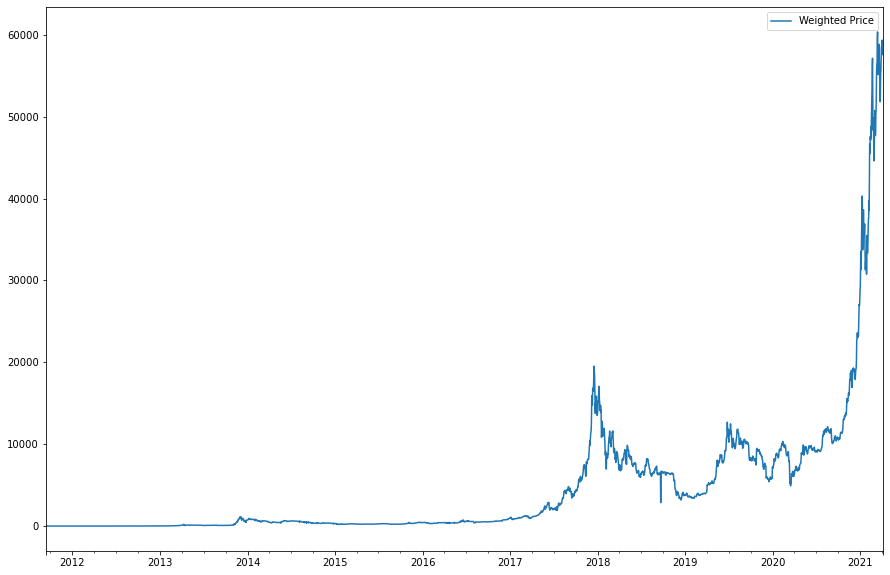

In [117]:
df_btc_data.groupby(df_btc_data.index).agg({'Weighted Price':'mean'}).plot(figsize=(15,10))